In [1]:
# Import necessary libraries
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import glob


def get_measurement(file_dir):

    # Specify the directory containing the .fit files (replace with your actual path)
    file_paths = sorted(glob.glob(file_dir + "*.fit"))

    # Initialize lists to store combined data and time axis
    combined_data = []
    time_offset = 0  # To manage time axis across multiple files
    time_axes = []  # To concatenate time axes properly

    # Loop through each .fit file
    for file_path in file_paths:
        hdul = fits.open(file_path)
        
        # Access data (assuming it's a 2D array with shape [frequency, time])
        data = hdul[0].data
        
        # Extract time axis (dummy axis if not provided in the header)
        time_axis = np.arange(data.shape[1]) + time_offset
        time_axes.append(time_axis)
        
        # Append data to the combined list
        combined_data.append(data)
        
        # Update time offset for the next file
        time_offset += data.shape[1]
        
        # Close the file
        hdul.close()

    # Concatenate all data and time axes
    combined_data = np.hstack(combined_data)  # Combine along the time axis
    time_axis_combined = np.hstack(time_axes)  # Combined time axis
    freq_axis = np.arange(combined_data.shape[0])  # Dummy frequency axis

    return time_axis_combined, freq_axis, combined_data






In [18]:

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def moving_average_smooth(data, window_size=3):
    """
    Smooths a 2D array along the first axis using a moving average.

    Parameters:
        data (ndarray): 2D array to be smoothed.
        window_size (int): Size of the moving average window.

    Returns:
        ndarray: Smoothed 2D array.
    """
    smoothed_data = np.apply_along_axis(
        lambda x: np.convolve(x, np.ones(window_size)/window_size, mode='same'),
        axis=0,
        arr=data
    )
    return smoothed_data


def gaussian(x, I, mu, sigma, A, B):
    return I * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) + A*x + B


def theoretical_fit(x, S, V, omega, delta):
    return S*(1+V*np.sin(omega*x+delta))






In [17]:
def get_V_omega_fromOneChannel(time, data):
    try:
        # Apply smoothing
        data = moving_average_smooth(data, window_size=10)

        # Fit the Gaussian function (using example Gaussian-like data)
        gaussian_params, _ = curve_fit(gaussian, time, data, p0=[17.5, 5720, 4640, 0, 140])
        I, mu, sigma, A, B = gaussian_params

        # Generate fitted values for plotting
        fitted_gaussian = gaussian(time, I, mu, sigma, A, B)



        """""
        # Gaussian plot
        plt.plot(time, data, label="Data (Gaussian)", color="green")
        plt.plot(time, fitted_gaussian, label=f"Fit: I={I:.2f}, μ={mu:.2f}, σ={sigma:.2f}, A={A:.2f}B={B:.2f}", color="purple")
        plt.title("Gaussian Fit")
        plt.xlabel("Time")
        plt.ylabel("Data")
        plt.legend()

        plt.tight_layout()
        plt.show()
        """

        data = data/fitted_gaussian


        fit_params, _ = curve_fit(theoretical_fit, time, data, p0=[1, 0.035, 0.0043, 5.6])
        S, V, omega, delta = fit_params

        """"
        # Generate fitted values for plotting
        fitted = theoretical_fit(time, S, V, omega, delta)
        print(fit_params)
        plt.plot(time, data, label="Data", color="green")
        plt.plot(time, fitted, label=f"Fit", color="purple")
        plt.title("Fit")
        plt.xlabel("Time")
        plt.ylabel("Data")
        plt.legend()

        plt.tight_layout()
        plt.show()
        """

        return np.abs(V), np.abs(omega)
        

    except Exception as e:
        # Log the exception for debugging purposes if needed
        # print(f"Fit failed: {e}")
        return 0, 0







In [19]:

file_dir_1 = "sun_meas_25/meas_1/"
file_dir_2 = "sun_meas_25/meas_2/"
file_dir_3 = "sun_meas_25/meas_3/"
file_dir_4 = "sun_meas_25/meas_4/"

time_1, freq_1, data_1 = get_measurement(file_dir_1)
time_2, freq_2, data_2 = get_measurement(file_dir_2)
time_3, freq_3, data_3 = get_measurement(file_dir_3)
time_4, freq_4, data_4 = get_measurement(file_dir_4)


frequency_index = 50  # Example: choose the 50th frequency
chosen_frequency = data_1[frequency_index]  # Get the actual frequency value if freq_axis is defined
frequency_range = np.arange(25,75+1)

visibilities_1 = np.empty(len(frequency_range), dtype=float)
omegas_1 = np.empty(len(frequency_range), dtype=float)
visibilities_2 = np.empty(len(frequency_range), dtype=float)
omegas_2 = np.empty(len(frequency_range), dtype=float)
visibilities_3 = np.empty(len(frequency_range), dtype=float)
omegas_3 = np.empty(len(frequency_range), dtype=float)
visibilities_4 = np.empty(len(frequency_range), dtype=float)
omegas_4 = np.empty(len(frequency_range), dtype=float)


for i, freq in enumerate(frequency_range):
    visibilities_1[i], omegas_1[i] = get_V_omega_fromOneChannel(time_1, data_1[freq])
    visibilities_2[i], omegas_2[i] = get_V_omega_fromOneChannel(time_2, data_2[freq])
    visibilities_3[i], omegas_3[i] = get_V_omega_fromOneChannel(time_3, data_3[freq])
    visibilities_4[i], omegas_4[i] = get_V_omega_fromOneChannel(time_4, data_4[freq])



In [22]:
def rep(arr):
    arr = arr.copy()  # Create a copy to avoid modifying the original array
    zero_indices = np.where(arr == 0)[0]  # Find indices where the values are zero

    for idx in zero_indices:
        # Find previous non-zero value
        prev_idx = idx - 1
        while prev_idx >= 0 and arr[prev_idx] == 0:
            prev_idx -= 1

        # Find next non-zero value
        next_idx = idx + 1
        while next_idx < len(arr) and arr[next_idx] == 0:
            next_idx += 1

        # Replace zero if both previous and next non-zero values exist
        if prev_idx >= 0 and next_idx < len(arr):
            arr[idx] = (arr[prev_idx] + arr[next_idx]) / 2

    return arr

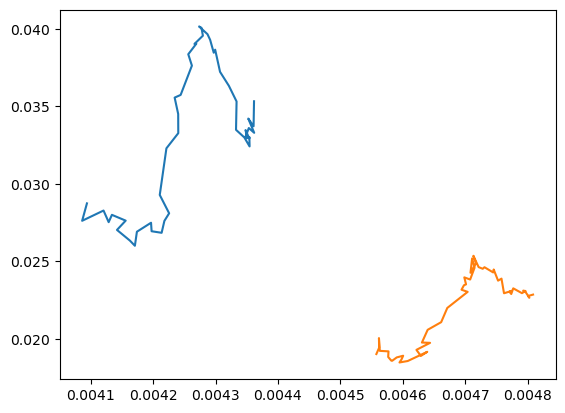

In [25]:
plt.plot(rep(omegas_1), rep(visibilities_1))
plt.plot(rep(omegas_2), rep(visibilities_2))




